In [1]:
import os
import time

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, UpSampling2D, Input
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from utils import config_gpu
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## introduction
- decoder in CAE: generator
    - generates image from an arbitrary vector
- how to train generator
    - simple idea: train CAE and remove encoder network
        - tends to produce blurred inaccurate image
- alternative1: VAE (Variational AutoEncoder)
    - also tends to be generate blurred image
- alternative2: DCGAN
    - use neural network as a loss function like in chapter11 (style transfer)
    - train generator and discriminator iteratively to keep the balance of both networks
- alternative3: BEGAN
    - use CAE as a discriminator
$$L_G = L(G(z_G))$$
$$L_D = L(x) - k_tL(G(z_G))$$
$$k_{t+1}=k_t + \lambda_k (\gamma L(x) - L(G(z_G)))$$
    - Notations
        - $x$: true image
        - $z_D,\; z_G$: arbitrary input vector of discriminator, generator
        - $L_G$: loss of generator network
            - $G(z_G)$: output of generator given input $z_G$
            - reconstruction error generator learns to minimize
        - $L_D$: loss of discriminator network 
            - $L(x)$: reconstruction error of true image
            - discriminator learns to minimize $L_D$
        - $k_t$: positive constant
            - weight for each recontruction error
                - minimize reconstruction error of true imgae
                - maximize reconstruction error of generated image
            - BEGAN automatically adjust this constant using a equation
            - $\lambda$: step size for updating $k_t$ (learning rate)
            - $\gamma$: balance reconstructure error between true and generated imgaes
                - small value means imitating true data
                - large value means generating many variations of image
        - $L$: MAE        

In [2]:
DATA_DIR = '../data/chap12/data/chap12/'
BATCH_SIZE = 16
IMG_SHAPE = (64, 64, 3)

n_filters = 64
n_layers = 4
z_size = 32

In [5]:
def build_encoder(input_shape, z_size, n_filters, n_layers):
    
    model = Sequential()
    model.add(
        Conv2D(
            n_filters,
            3,
            activation='elu',
            input_shape=input_shape,
            padding='same'
        )
    )
    model.add(Conv2D(n_filters, 3, padding='same'))
    for i in range(2, n_layers+1):
        model.add(
            Conv2D(
                i*n_filters,
                3,
                activation='elu',
                padding='same'
            )
        )
        model.add(
            Conv2D(
                i*n_filters,
                3,
                strides=2,
                activation='elu',
                padding='same'
            )
        )
    model.add(Conv2D(n_layers*n_filters, 3, padding='same'))
    model.add(Flatten())
    model.add(Dense(z_size))
    
    return model

In [6]:
def build_decoder(output_shape, z_size, n_filters, n_layers):
    
    scale = 2**(n_layers-1)
    
    fc_shape = (
        output_shape[0] // scale,
        output_shape[1] // scale,
        n_filters
    )    
    fc_size = fc_shape[0]*fc_shape[1]*fc_shape[2]
    
    model = Sequential()
    model.add(Dense(fc_size, input_shape=(z_size, )))
    model.add(Reshape(fc_shape))
    
    for i in range(n_layers-1):
        model.add(
            Conv2D(
                n_filters,
                3,
                activation='elu',
                padding='same'
            )
        )
        model.add(
            Conv2D(
                n_filters,
                3,
                activation='elu',
                padding='same'
            )
        )
        model.add(UpSampling2D())
        
    model.add(
        Conv2D(
            n_filters,
            3,
            activation='elu',
            padding='same'
        )
    )
    model.add(
        Conv2D(
            n_filters,
            3,
            activation='elu',
            padding='same'
        )
    )
    model.add(Conv2D(3, 3, padding='same'))
    
    return model

In [7]:
def build_generator(img_shape, z_size, n_filters, n_layers):
    
    decoder = build_decoder(
        img_shape, z_size, n_filters, n_layers
    )
    
    return decoder

def build_discriminator(img_shape, z_size, n_filters, n_layers):
    
    encoder = build_encoder(
        img_shape, z_size, n_filters, n_layers
    )
    decoder = build_decoder(
        img_shape, z_size, n_filters, n_layers
    )
    
    return Sequential((encoder, decoder))

In [8]:
def build_discriminator_trainer(discriminator):
    
    img_shape = discriminator.input_shape[1:]
    real_inputs = Input(img_shape)
    fake_inputs = Input(img_shape)
    real_outputs = discriminator(real_inputs)
    fake_outputs = discriminator(fake_inputs)
    
    return Model(inputs=[real_inputs, fake_inputs],
                 outputs=[real_outputs, fake_outputs])

In [9]:
def build_generator_loss(discriminator):
    
    def loss(y_true, y_pred):
        reconst = discriminator(y_pred)
        return mean_absolute_error(
            reconst,
            y_pred
        )
    
    return loss


# convergence test
def measure(real_loss, fake_loss, gamma):
    
    return real_loss + np.abs(gamma*real_loss - fake_loss)

In [10]:
def save_imgs(path, imgs, rows, cols):
    
    base_width = imgs.shape[1]
    base_height = imgs.shape[2]
    channels = imgs.shape[3]
    output_shape = (
        base_height*rows,
        base_width*cols,
        channels
    )
    buffer = np.zeros(output_shape)
    for row in range(rows):
        for col in range(cols):
            img = imgs[row*cols + col]
            buffer[
                row*base_height:(row + 1)*base_height,
                col*base_width:(col + 1)*base_width
            ] = img
    array_to_img(buffer).save(path)

In [ ]:
data_gen = ImageDataGenerator(rescale=1/255.)

train_data_generator = data_gen.flow_from_directory(
    directory=DATA_DIR,
    classes=['faces'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    target_size=IMG_SHAPE[:2]
)

In [11]:
generator = build_generator(
    IMG_SHAPE, z_size, n_filters, n_layers
)
discriminator = build_discriminator(
    IMG_SHAPE, z_size, n_filters, n_layers
)
discriminator_trainer = build_discriminator_trainer(discriminator)

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              135168    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [13]:
discriminator.layers[1].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              135168    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)       

In [14]:
# compile generator
# initial learning rate
g_lr = 0.0001

generator_loss = build_generator_loss(discriminator)
generator.compile(
    loss=generator_loss,
    optimizer=Adam(g_lr)
)

# compile discriminator
# initial learning rate
d_lr = 0.0001

k_var = 0.0
k = K.variable(k_var)
discriminator_trainer.compile(
    loss=[
        mean_absolute_error,
        mean_absolute_error
    ],
    loss_weights=[1., -k],
    optimizer=Adam(d_lr)
)

In [15]:
GAMMA = 0.5
LR_K = 0.001
TOTAL_STEPS = 100000

MODEL_SAVE_DIR = '../model/began_s/models'
IMG_SAVE_DIR = '../model/began_s/imgs'

# generate 5x5 image for verification
IMG_SAMPLE_SHAPE = (5, 5)
N_IMG_SAMPLES = np.prod(IMG_SAMPLE_SHAPE)

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(IMG_SAVE_DIR, exist_ok=True)

sample_seeds = np.random.uniform(
    -1, 1, (N_IMG_SAMPLES, z_size)
)
history = []
logs = []

In [16]:
for step, batch in enumerate(train_data_generator):
    
    # if the number of images are not multiple of batch_size
    if len(batch) < BATCH_SIZE:
        continue
        
    # quit traning
    if step > TOTAL_STEPS:
        break
        
    z_g = np.random.uniform(
        -1, 1, (BATCH_SIZE, z_size)
    )
    z_d = np.random.uniform(
        -1, 1, (BATCH_SIZE, z_size)
    )
    
    # generate image to use for training generator
    g_pred = generator.predict(z_d)
    
    # train generator 1-step
    generator.train_on_batch(z_g, batch)
    
    # train discriminator 1-step
    _, real_loss, fake_loss = discriminator_trainer.train_on_batch(
        [batch, g_pred],
        [batch, g_pred]
    )
    
    # update k
    k_var += LR_K*(GAMMA*real_loss - fake_loss)
    K.set_value(k, k_var)
    
    # save loss for calculating g_measure
    history.append({
        'real_loss': real_loss,
        'fake_loss': fake_loss,
    })
    
    # print log for each 1000 iterations
    if step % 1000 == 0:
        # loss for past 1000 measures
        measurement = np.mean([
            measure(loss['real_loss'],
                    loss['fake_loss'],
                    GAMMA)
            for loss in history[-1000:]
        ])
        
        # print current log
        logs.append({
            'k': K.get_value(k),
            'measure': measurement,
            'real_loss': real_loss,
            'fake_loss': fake_loss
        })
        print(logs[-1])
        
        # save image
        img_path = '{}/generated_{}.png'.format(
            IMG_SAVE_DIR,
            step
        )        
        save_imgs(
            img_path,
            generator.predict(sample_seeds),
            rows=IMG_SAMPLE_SHAPE[0],
            cols=IMG_SAMPLE_SHAPE[1]
        )
        
        # save recent model
        generator.save('{}/generator_{}.hd5'.
                       format(MODEL_SAVE_DIR, step))
        discriminator.save('{}/discriminator_{}.hd5'.
                           format(MODEL_SAVE_DIR,step))
        
        print('\n')

{'k': 0.00015198493, 'measure': 0.5555489137768745, 'real_loss': 0.40356398, 'fake_loss': 0.04979705}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../model/began_s/models/generator_0.hd5/assets
INFO:tensorflow:Assets written to: ../model/began_s/models/discriminator_0.hd5/assets


KeyboardInterrupt: 

In [2]:
from utils import load_img

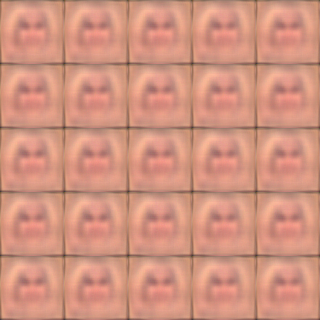

In [14]:
img = load_img('../model/began_s/imgs/generated_9000.png')
img